In [1]:
from self_supervised_halos.utils.utils import data_preprocess_path, check_cuda
from scripts.classification_2d import ClassificationModel, report_classification_performance

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = check_cuda()

Running on local machine
matplotlib settings set
CUDA is not available.
Device: cpu


In [2]:
dataset = HaloDataset(root_dir=data_preprocess_path,subhalos_df=subhalos_df, 
                      load_2d=True, load_3d=False, load_mass=False,
                        choose_two_2d = False,
                      DEBUG_LIMIT_FILES = None)

if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Preparing 2D data: 100%|██████████| 16544/16544 [00:39<00:00, 420.08it/s]

Batch size: 128


In [3]:
lr = 1e-3
n_epochs=10


criterion = nn.CrossEntropyLoss(weight=dataset.mass_bins_weights.to(device)).to(device)

model = ClassificationModel(
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr':lr},
                    scheduler_class=torch.optim.lr_scheduler.StepLR,
                    scheduler_params={'step_size':10, 'gamma':0.1},
                    criterion=criterion,
                    history=None
)

model.load('Classification_2d.pth')

model.trial_forward_pass(train_loader, device);

Model Classification_2d loaded at epoch 20


Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.23731505870819092
Outputs shape: torch.Size([128, 10])


In [5]:
model.training_loop(
    train_loader=train_loader, 
    val_loader=val_loader,
    num_epochs=n_epochs, 
    device=device)

Epoch 1/10 Training: 100%|██████████| 78/78 [00:04<00:00, 16.03it/s]


Epoch 1, Training Loss: 0.25477394958337146


Epochs:  10%|█         | 1/10 [00:05<00:51,  5.71s/it]

Epoch 1, Validation Loss: 0.2711714655160904


Epoch 2/10 Training: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s]


Epoch 2, Training Loss: 0.262298682370247


Epochs:  20%|██        | 2/10 [00:13<00:56,  7.08s/it]

Epoch 2, Validation Loss: 0.2719669875044089


Epoch 3/10 Training: 100%|██████████| 78/78 [00:04<00:00, 16.48it/s]


Epoch 3, Training Loss: 0.26063542927686983


Epochs:  30%|███       | 3/10 [00:19<00:45,  6.45s/it]

Epoch 3, Validation Loss: 0.27807941230443806


Epoch 4/10 Training: 100%|██████████| 78/78 [00:05<00:00, 14.42it/s]


Epoch 4, Training Loss: 0.2621274995498168


Epochs:  40%|████      | 4/10 [00:26<00:39,  6.58s/it]

Epoch 4, Validation Loss: 0.27415780837719256


Epoch 5/10 Training: 100%|██████████| 78/78 [00:07<00:00,  9.94it/s]


Epoch 5, Training Loss: 0.26418675291232574


Epochs:  50%|█████     | 5/10 [00:35<00:37,  7.49s/it]

Epoch 5, Validation Loss: 0.26423531197584593


Epoch 6/10 Training: 100%|██████████| 78/78 [00:06<00:00, 12.92it/s]


Epoch 6, Training Loss: 0.25597382336854935


Epochs:  60%|██████    | 6/10 [00:42<00:29,  7.40s/it]

Epoch 6, Validation Loss: 0.272668712414228


Epoch 7/10 Training: 100%|██████████| 78/78 [00:06<00:00, 12.82it/s]


Epoch 7, Training Loss: 0.2564681682449121


Epochs:  70%|███████   | 7/10 [00:49<00:21,  7.30s/it]

Epoch 7, Validation Loss: 0.2684871330857277


Epoch 8/10 Training: 100%|██████████| 78/78 [00:05<00:00, 14.85it/s]


Epoch 8, Training Loss: 0.2594552206305357


Epochs:  80%|████████  | 8/10 [00:56<00:14,  7.11s/it]

Epoch 8, Validation Loss: 0.2717184556218294


Epoch 9/10 Training: 100%|██████████| 78/78 [00:06<00:00, 12.77it/s]


Epoch 9, Training Loss: 0.2527510628868372


Epochs:  90%|█████████ | 9/10 [01:03<00:07,  7.10s/it]

Epoch 9, Validation Loss: 0.26577682277330983


Epoch 10/10 Training: 100%|██████████| 78/78 [00:04<00:00, 15.64it/s]


Epoch 10, Training Loss: 0.25878106439724946


Epochs: 100%|██████████| 10/10 [01:09<00:00,  6.94s/it]

Epoch 10, Validation Loss: 0.26998172299220013


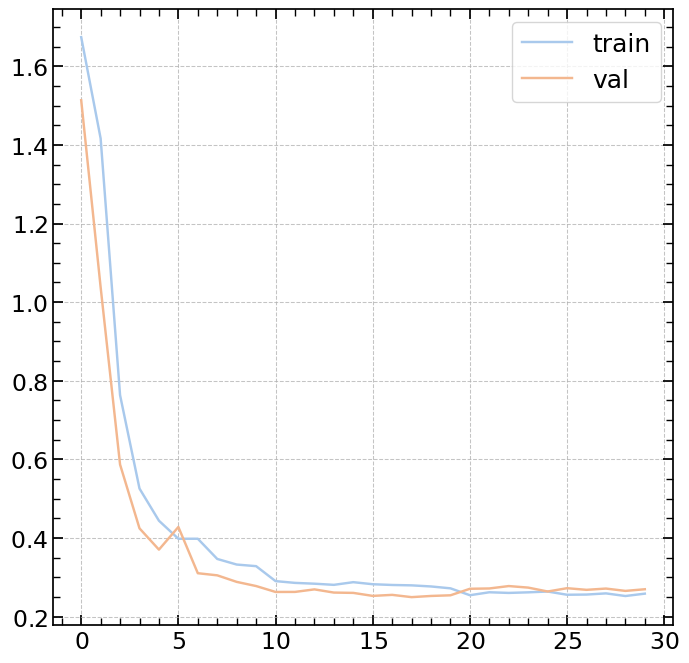

In [6]:
%matplotlib inline
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['val_loss'], label='val')
plt.legend()
plt.show()

In [11]:
#test saving
model.save()

Model Classification_2d saved at epoch 30


In [12]:
model.history

{'train_loss': [1.6739236498490357,
  1.4163606717036321,
  0.7635375693058356,
  0.526026230209913,
  0.4442487485133685,
  0.3983464168432431,
  0.3983952536796912,
  0.3470216089716324,
  0.3327882649042668,
  0.32868246256540984,
  0.2906559060017268,
  0.28616429769839996,
  0.28408886052859134,
  0.2811695797703205,
  0.28794988187459797,
  0.2827341470580835,
  0.2808427380827757,
  0.27987068547652316,
  0.277065926637405,
  0.2722967633834252,
  0.25477394958337146,
  0.262298682370247,
  0.26063542927686983,
  0.2621274995498168,
  0.26418675291232574,
  0.25597382336854935,
  0.2564681682449121,
  0.2594552206305357,
  0.2527510628868372,
  0.25878106439724946],
 'val_loss': [1.513577360373277,
  1.0380518986628606,
  0.587074474646495,
  0.42479359071988326,
  0.3707057558573209,
  0.42829496126908523,
  0.31073884608653873,
  0.30534301755520016,
  0.2887057363986969,
  0.2781085985211226,
  0.2630778413552504,
  0.2631869860566579,
  0.2696358939776054,
  0.26151138830643

Classification Performance: 26it [00:00, 29.31it/s]
Classification Performance: 0it [00:00, ?it/s]


pred_class,0,1,2,3,4,5,6,7,8,All
true_class,,,,,,,,,,
0,1692,63,0,0,0,0,0,0,0,1755
1,72,708,47,0,0,0,0,0,0,827
2,0,35,339,14,0,0,0,0,0,388
3,0,0,21,139,8,0,0,0,0,168
4,0,0,0,13,77,1,0,0,0,91
5,0,0,0,0,21,27,3,0,0,51
6,0,0,0,0,0,10,5,0,0,15
7,0,0,0,0,0,0,3,8,0,11
8,0,0,0,0,0,0,0,2,0,2


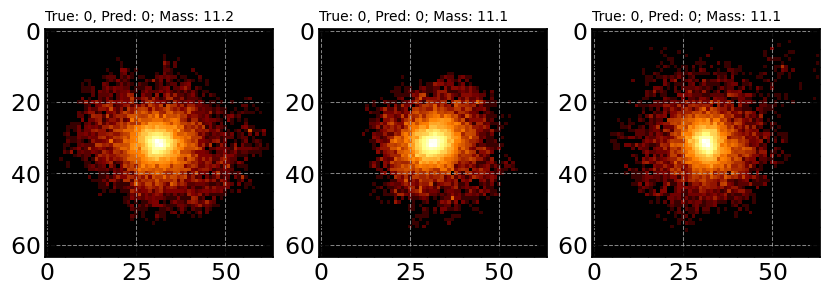

In [29]:
result_df = report_classification_performance(model, val_loader, device=device)
report_classification_performance(model, val_loader, device=device, viz_one = True)

pd.crosstab(result_df['true_class'], result_df['pred_class'], margins=True)


Classification Performance: 26it [00:00, 26.05it/s]
Classification Performance: 0it [00:00, ?it/s]


pred_class,0,1,2,3,4,5,6,7,8,All
true_class,,,,,,,,,,
0,1600,84,0,0,0,0,0,0,0,1684
1,85,760,35,0,0,0,0,0,0,880
2,0,52,340,24,0,0,0,0,0,416
3,0,0,15,148,11,0,0,0,0,174
4,0,0,0,12,70,3,0,0,0,85
5,0,0,0,0,17,27,3,0,0,47
6,0,0,0,0,0,8,8,0,0,16
7,0,0,0,0,0,0,1,3,0,4
8,0,0,0,0,0,0,0,1,1,2


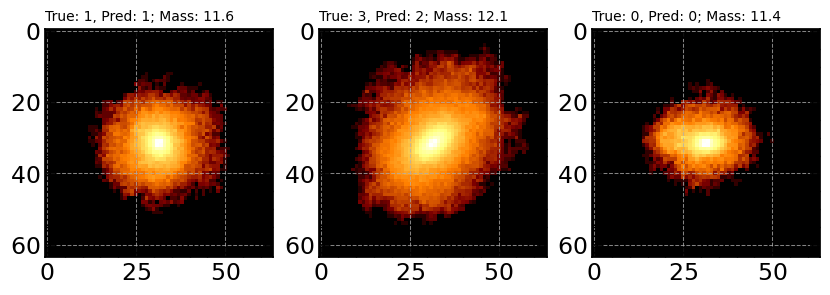

In [28]:
result_df_test = report_classification_performance(model, test_loader, device=device)
report_classification_performance(model, test_loader, device=device, viz_one = True)

pd.crosstab(result_df_test['true_class'], result_df_test['pred_class'], margins=True)


In [123]:
#test of min of all images correlates with the label/mass

masses = []
mins = []
for batch in train_loader:
    img, label = batch
    img = img[0]

    min_on_img_per_batch = torch.where(img==img, img, torch.inf).view(img.size(0), -1).min(dim=1)[0]
    mass = label[0]

    masses.append(mass)
    mins.append(min_on_img_per_batch)

    

In [124]:
masses_np = torch.cat(masses).numpy()

mins_np = torch.cat(mins).numpy()

In [128]:
len(mins_np), len(masses_np)

(9925, 9925)

Text(0, 0.5, 'min of transformed 2d image')

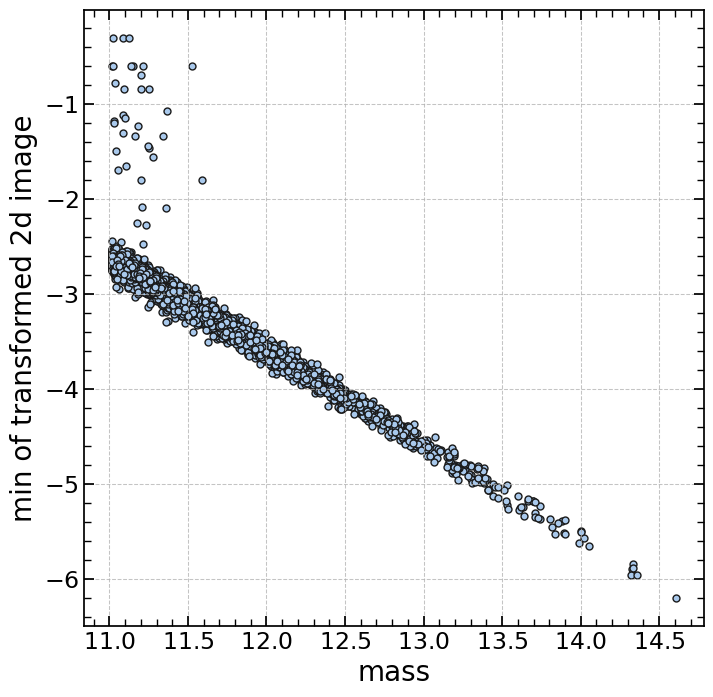

In [134]:
plt.scatter(masses_np, mins_np)
plt.xlabel('mass')
plt.ylabel('min of transformed 2d image')


In [132]:
dataset.__getitem_2d__(idx = 50)[0]

array([[-5.274977, -5.274977, -5.274977, ..., -5.274977, -5.274977,
        -5.274977],
       [-5.274977, -5.274977, -5.274977, ..., -5.274977, -5.274977,
        -5.274977],
       [-5.274977, -5.274977, -5.274977, ..., -5.274977, -5.274977,
        -5.274977],
       ...,
       [-5.274977, -5.274977, -5.274977, ..., -5.274977, -5.274977,
        -5.274977],
       [-5.274977, -5.274977, -5.274977, ..., -5.274977, -5.274977,
        -5.274977],
       [-5.274977, -5.274977, -5.274977, ..., -5.274977, -5.274977,
        -5.274977]], dtype=float32)